# 🛍️ Predicting Purchases with Google Analytics Session Data

### 📄 Overview
This dataset simulates user behavior on an e-commerce website using Google Analytics session-level data. Each row represents a unique session, with various behavioral, traffic source, and device-related attributes. The goal is to predict whether a user will make a purchase on a return visit, based on information from their current session.

This type of problem is common in real-world digital marketing, product analytics, and conversion optimization tasks.

### 🎯 Objective
Your task is to build a model that predicts the binary outcome:
'Will the user make a purchase if they return in a later session?'

This can help businesses understand visitor intent, personalize user experience, and retarget high-quality traffic.

### 📌 Target Column
will_buy_on_return_visit: Binary classification label:
*   1: User returned later and made a purchase.
* 0: User did not return or did not convert.





#Import Lybraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

#Data Loading

In [74]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [75]:
print("Loading data files...")
try:
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    sample_submission = pd.read_csv('sample_submission.csv')
    print("Data files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")

Loading data files...
Data files loaded successfully!


# 1. Data Exploration and Understanding

In [76]:
print("\nTraining data shape:", train_data.shape)
print("\nTest data shape:", test_data.shape)
print("\nSample of training data:")
print(train_data.head())


Training data shape: (4000, 18)

Test data shape: (1000, 17)

Sample of training data:
   id              unique_session_id  bounces  time_on_site  pageviews  hits  \
0   0  98463921871485068561470319157        0          2818         68    86   
1   1  64969931561991723631486389718        0            32          4     4   
2   2   2117346273301973411473489944        0            93          8    11   
3   3   8934726040229318731481512421        0           265         15    21   
4   4   5054831196771327751486859045        1             0          1     1   

   session_quality_dim  latest_ecommerce_progress  avg_time_per_page  \
0                    0                          6          41.992188   
1                    0                          0           8.000000   
2                    0                          2          11.625000   
3                    0                          2          17.333333   
4                    0                          0                NaN   

In [77]:
print("\nData types in training data:")
print(train_data.dtypes)

print("\nMissing values in training data:")
print(train_data.isnull().sum())

print("\nNan values in training data:")
print(train_data.isna().sum())


Data types in training data:
id                             int64
unique_session_id             object
bounces                        int64
time_on_site                   int64
pageviews                      int64
hits                           int64
session_quality_dim            int64
latest_ecommerce_progress      int64
avg_time_per_page            float64
source                        object
medium                        object
channelGrouping               object
deviceCategory                object
operatingSystem               object
browser                       object
country                       object
city                          object
will_buy_on_return_visit       int64
dtype: object

Missing values in training data:
id                              0
unique_session_id               0
bounces                         0
time_on_site                    0
pageviews                       0
hits                            0
session_quality_dim             0
latest_ecommerce_p

In [78]:
print("\nTarget variable distribution:")
print(train_data['will_buy_on_return_visit'].value_counts())
print(train_data['will_buy_on_return_visit'].value_counts(normalize=True))


Target variable distribution:
will_buy_on_return_visit
1    2009
0    1991
Name: count, dtype: int64
will_buy_on_return_visit
1    0.50225
0    0.49775
Name: proportion, dtype: float64


# 2. Exploratory Data Analysis (EDA)

In [79]:
# Explore numerical features
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'will_buy_on_return_visit' and col != 'id']

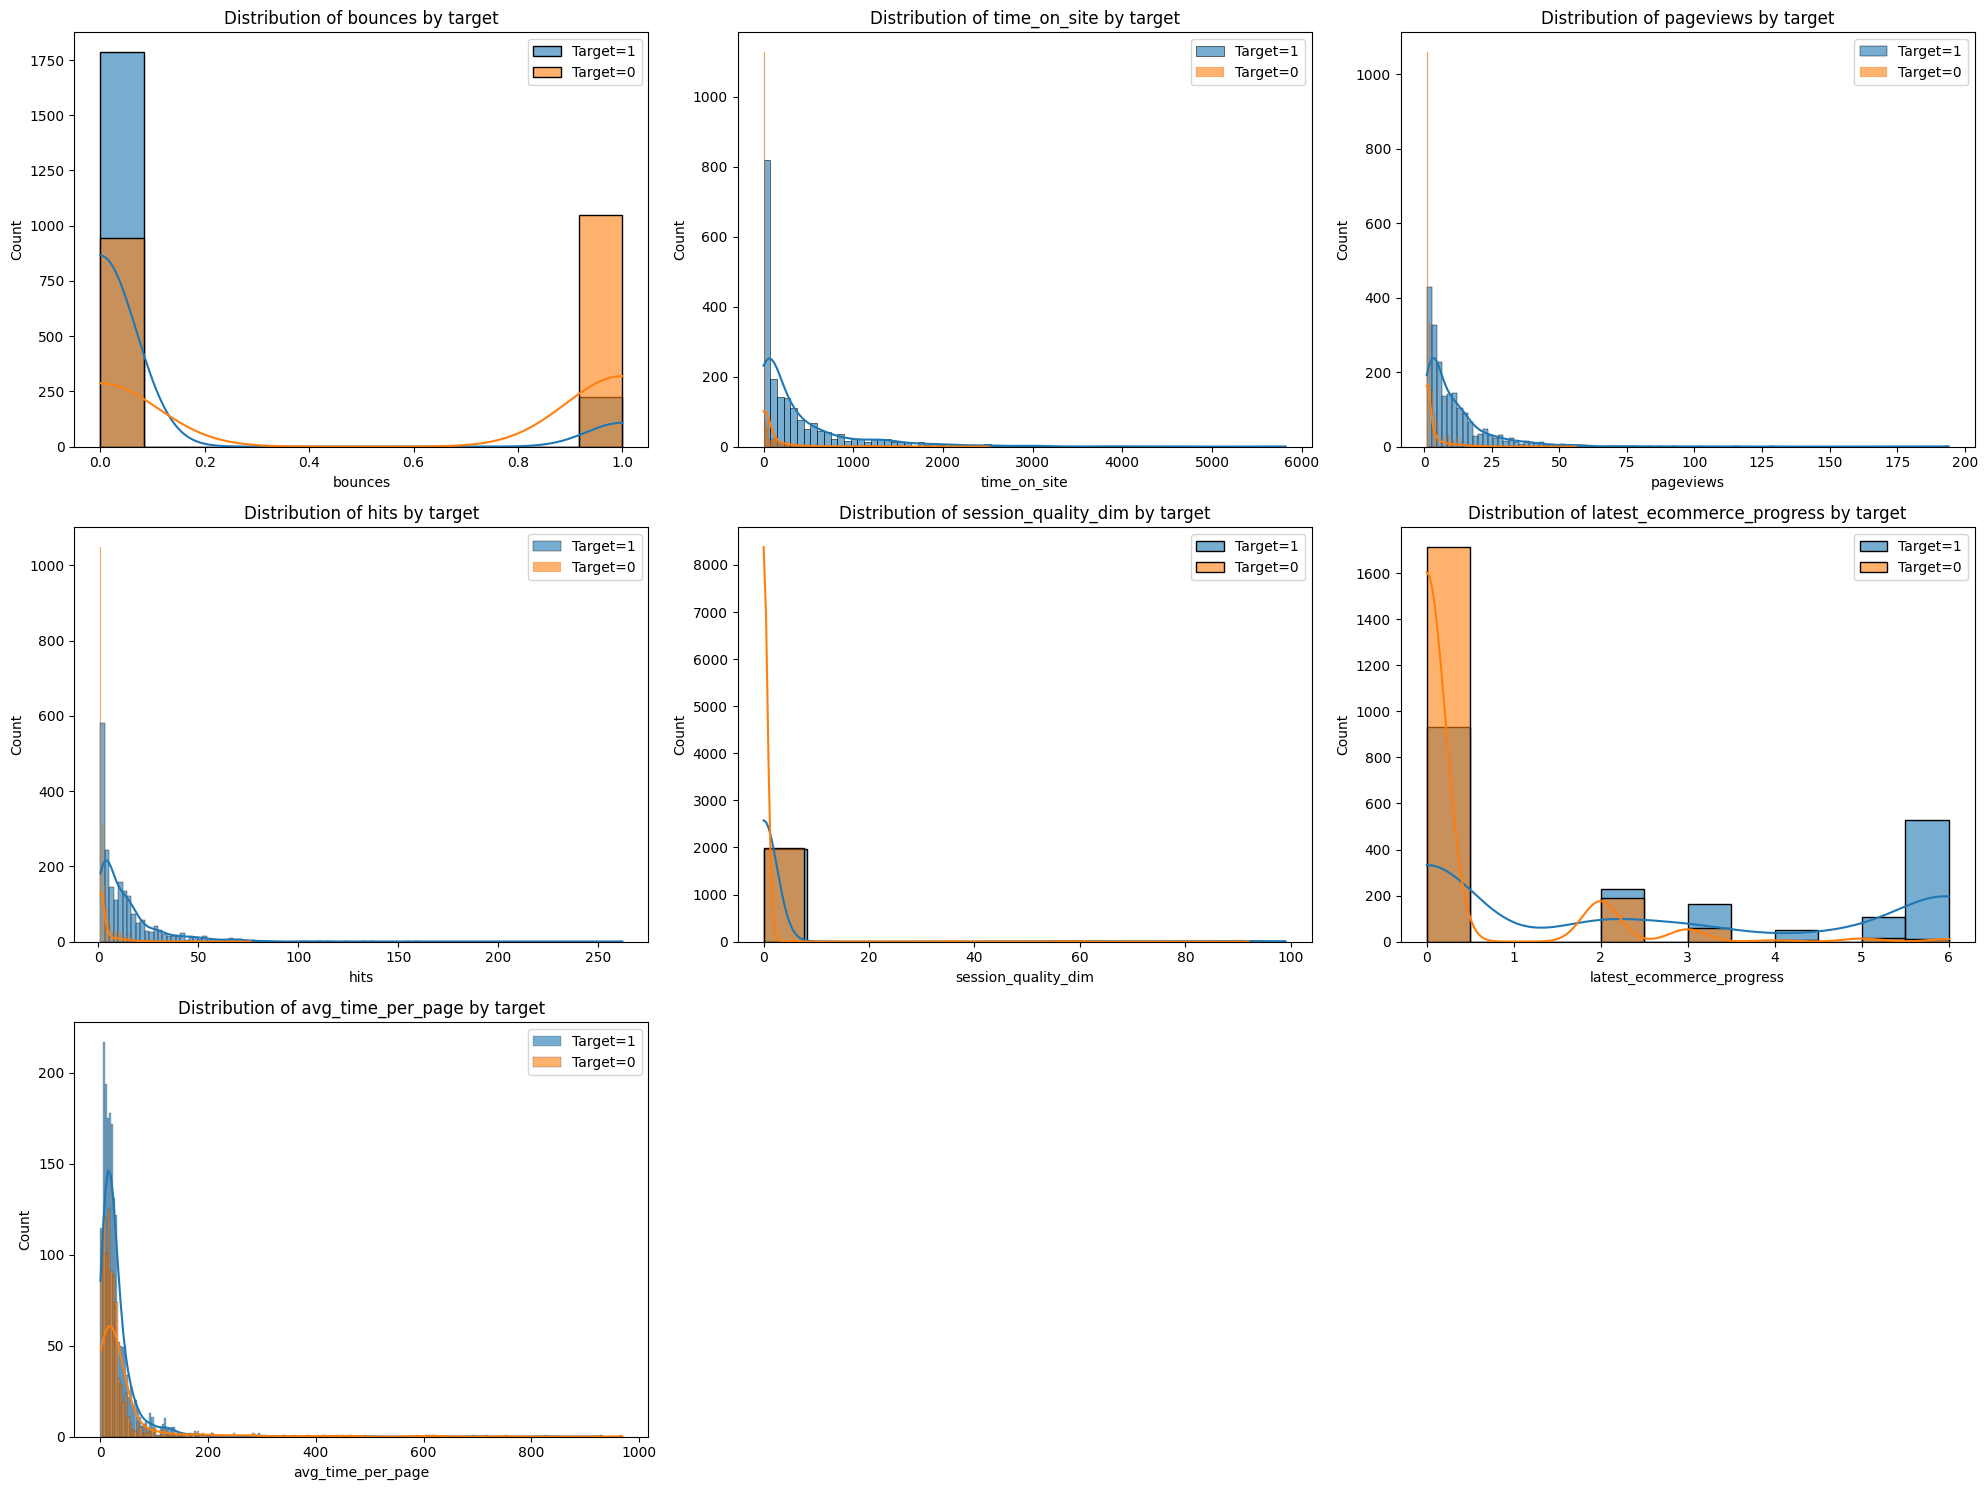

In [ ]:
# Create histograms for numerical features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols[:9], 1):  # Limit to 9 features for clarity
    plt.subplot(3, 3, i)
    for target_val in train_data['will_buy_on_return_visit'].unique():
        sns.histplot(
            train_data[train_data['will_buy_on_return_visit'] == target_val][col],
            kde=True,
            label=f'Target={target_val}',
            alpha=0.6
        )
    plt.title(f'Distribution of {col} by target')
    plt.legend()
plt.tight_layout()
plt.show()

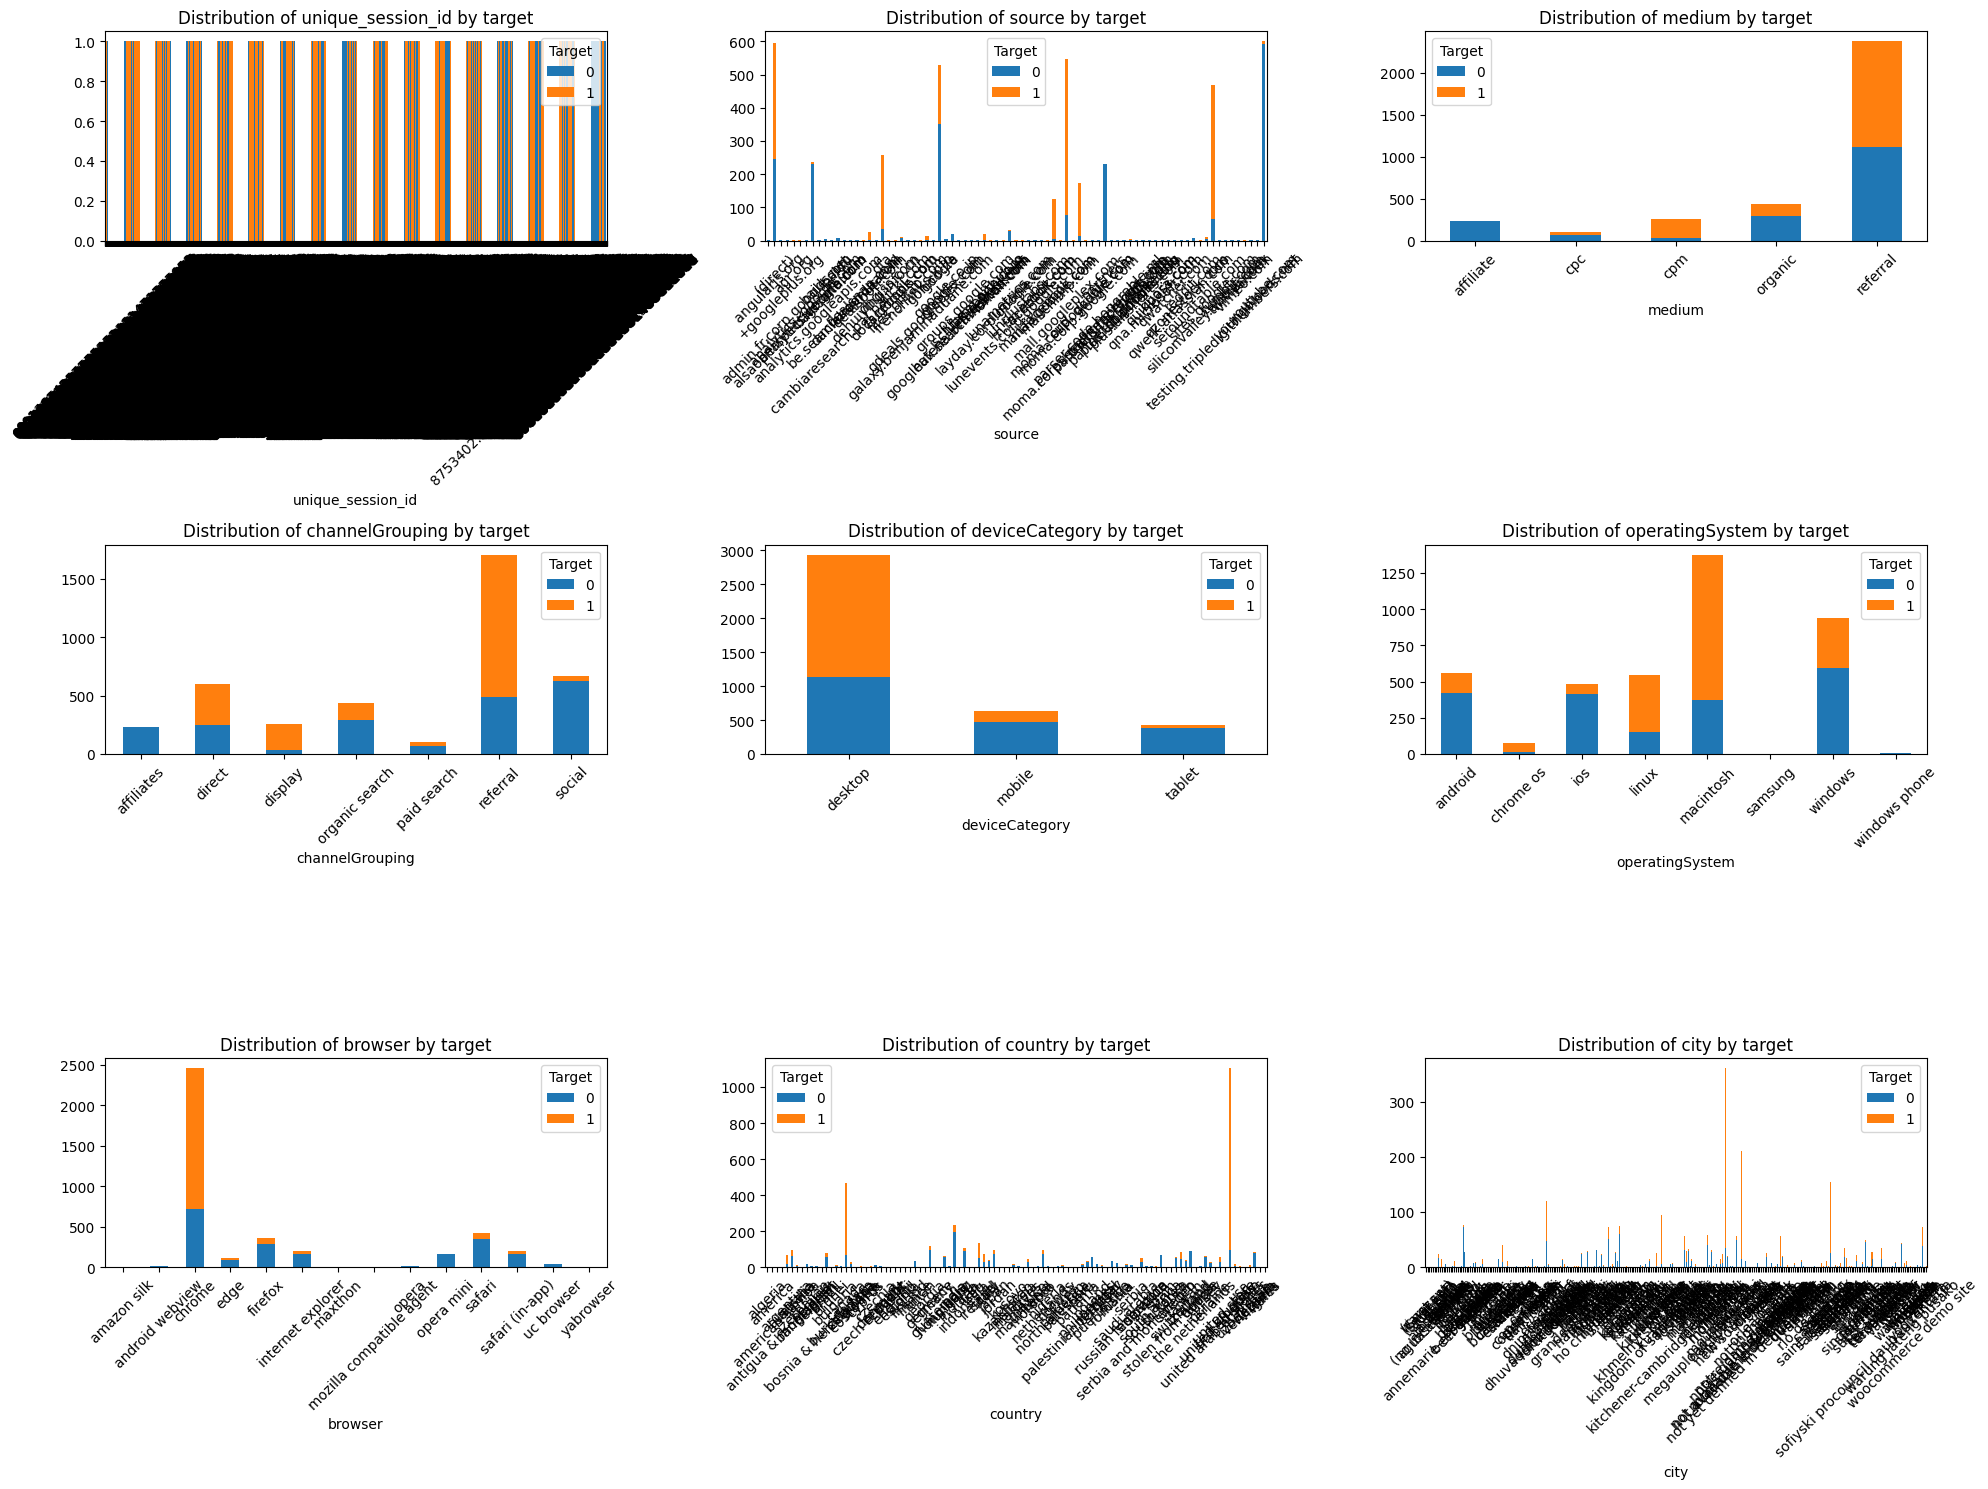

In [80]:
# Explore categorical features
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    plt.figure(figsize=(20, 15))

    for i, col in enumerate(categorical_cols[:9], 1):  # Limit to 9 features
        plt.subplot(3, 3, i)

        # Group by categorical column and target
        df_grouped = train_data.groupby([col, 'will_buy_on_return_visit']).size().unstack()

        # Plot stacked bar chart
        df_grouped.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title(f'Distribution of {col} by target')
        plt.xticks(rotation=45)
        plt.legend(title='Target')

    plt.tight_layout()
    plt.show()

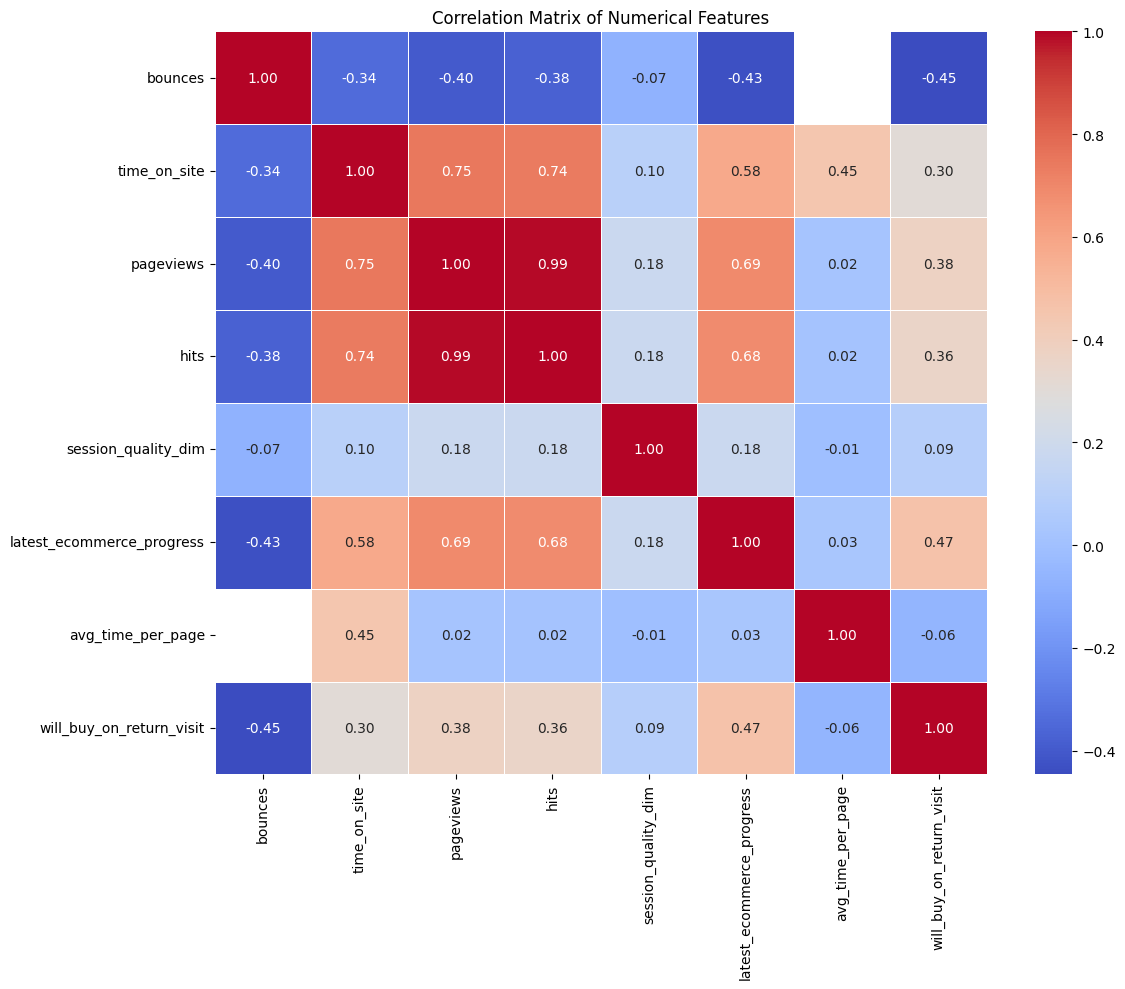

In [82]:
# Correlation analysis for numerical features
corr_matrix = train_data[numerical_cols + ['will_buy_on_return_visit']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

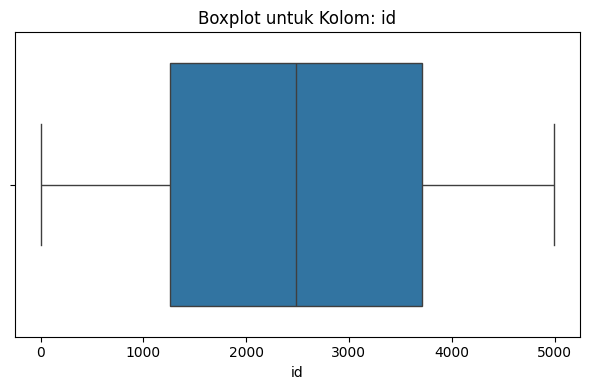

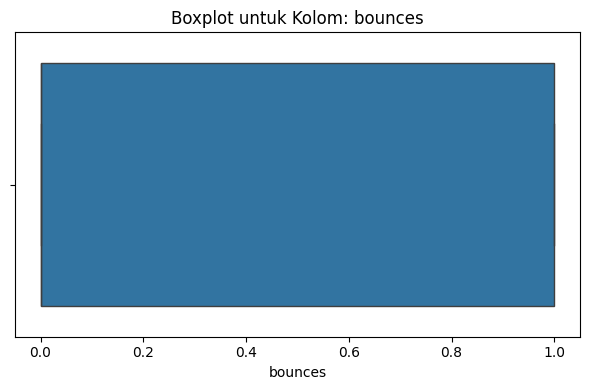

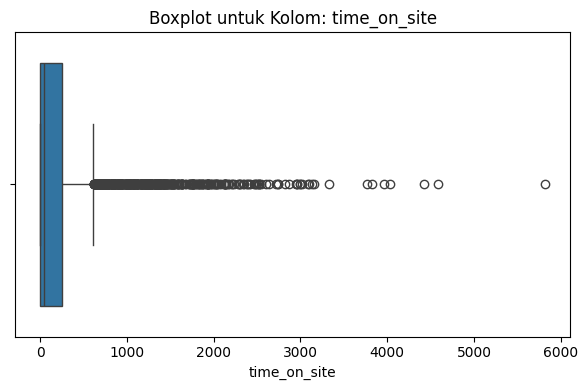

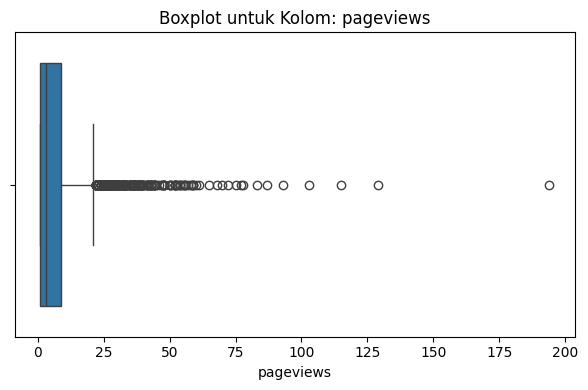

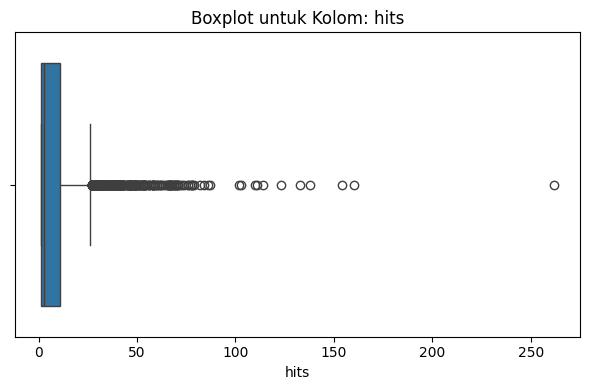

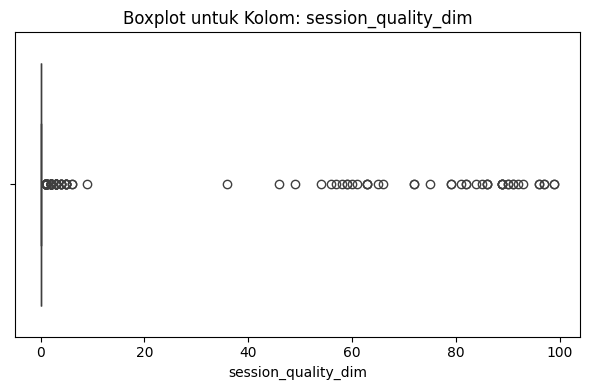

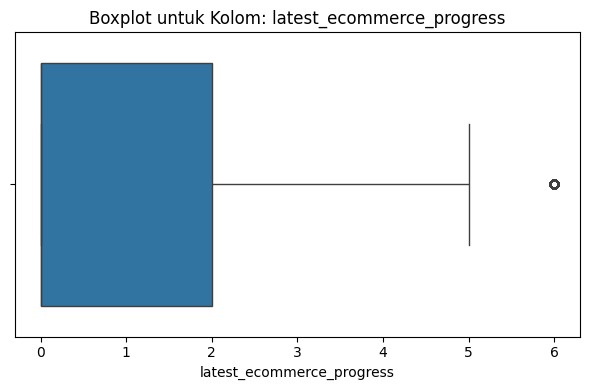

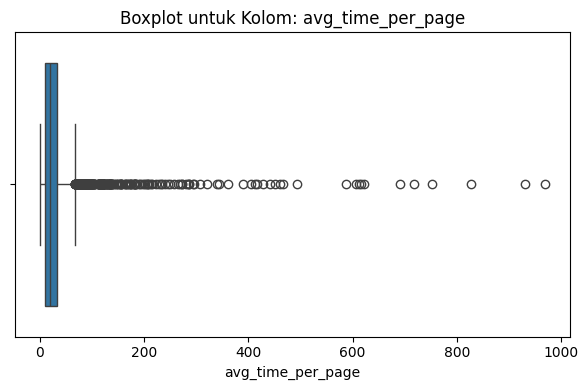

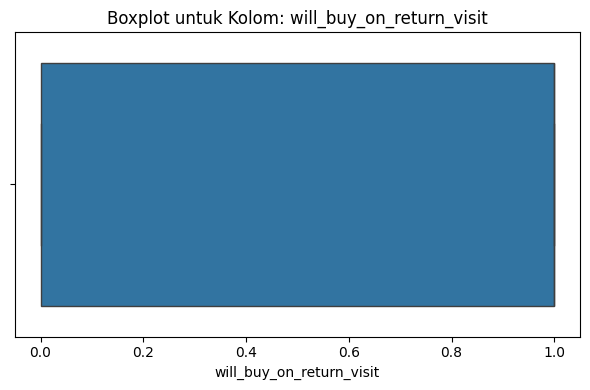

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hanya ambil kolom numerik
numeric_cols = train_data.select_dtypes(include='number')

# Loop setiap kolom
for col in numeric_cols.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot untuk Kolom: {col}')
    plt.tight_layout()
    plt.show()


# 3. Feature Engineering

In [85]:
# Function to engineer features for both train and test sets
def engineer_features(df):
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()

    # Create new features from existing ones

    # 1. Engagement metrics
    if 'time_on_site' in df.columns and 'pageviews' in df.columns:
        # Time per page - how focused the user is on each page
        df_processed['avg_time_per_page'] = df['time_on_site'] / df['pageviews'].replace(0, 1)

    if 'hits' in df.columns and 'pageviews' in df.columns:
        # Interactions per page - how interactive the user is per page
        df_processed['interactions_per_page'] = df['hits'] / df['pageviews'].replace(0, 1)

    # 2. Log transforms for skewed numerical columns
    for col in ['time_on_site', 'pageviews', 'hits']:
        if col in df.columns:
            df_processed[f'log_{col}'] = np.log1p(df[col])

    # 3. Engineered interaction features
    if 'session_quality_dim' in df.columns and 'pageviews' in df.columns:
        df_processed['quality_per_pageview'] = df['session_quality_dim'] / df['pageviews'].replace(0, 1)

    if 'session_quality_dim' in df.columns and 'time_on_site' in df.columns:
        df_processed['quality_per_time'] = df['session_quality_dim'] / df['time_on_site'].replace(0, 1)

    # 4. Bounces are important - maybe amplify this signal
    if 'bounces' in df.columns:
        df_processed['bounces_flag'] = (df['bounces'] > 0).astype(int)

    return df_processed

In [86]:
# Apply feature engineering to train and test datasets
train_engineered = engineer_features(train_data)
test_engineered = engineer_features(test_data)

print("Feature engineering completed.")
print("New features in training data:")
new_features = [col for col in train_engineered.columns if col not in train_data.columns]
print(new_features)

Feature engineering completed.
New features in training data:
['interactions_per_page', 'log_time_on_site', 'log_pageviews', 'log_hits', 'quality_per_pageview', 'quality_per_time', 'bounces_flag']


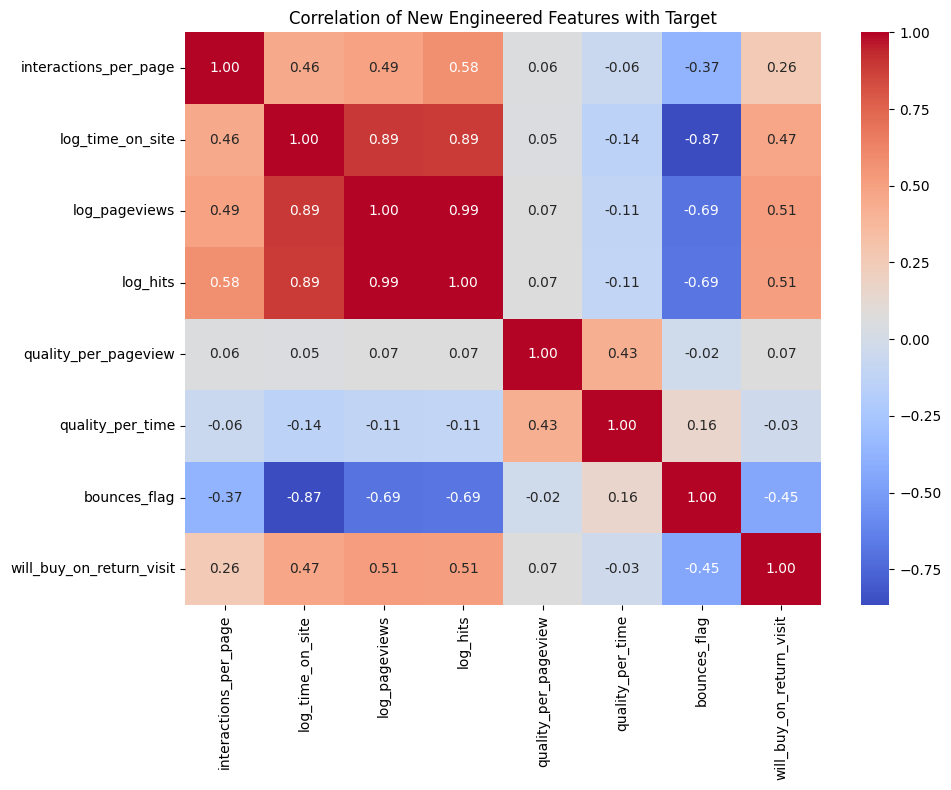

In [87]:
# Look at correlations for new engineered features
if len(new_features) > 0:
    new_features_with_target = new_features + ['will_buy_on_return_visit']
    new_features_corr = train_engineered[new_features_with_target].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(new_features_corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation of New Engineered Features with Target')
    plt.tight_layout()
    plt.show()

# 4. Data Preprocessing For Modeling

In [ ]:
# Identify feature types
if 'will_buy_on_return_visit' in train_engineered.columns:
    target = 'will_buy_on_return_visit'
    features = [col for col in train_engineered.columns if col != target and col != 'id']
else:
    print("Target column not found in training data")
    features = [col for col in train_engineered.columns if col != 'id']

In [ ]:
# Identify categorical and numerical features
categorical_features = train_engineered[features].select_dtypes(include=['object']).columns.tolist()
numerical_features = train_engineered[features].select_dtypes(exclude=['object']).columns.tolist()

print(f"Target column: {target}")
print(f"Number of features: {len(features)}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

Target column: will_buy_on_return_visit
Number of features: 20
Categorical features (9): ['unique_session_id', 'source', 'medium', 'channelGrouping', 'deviceCategory', 'operatingSystem', 'browser', 'country', 'city']
Numerical features (11): ['bounces', 'time_on_site', 'pageviews', 'hits', 'session_quality_dim', 'latest_ecommerce_progress', 'avg_time_per_page', 'interactions_per_page', 'log_time_on_site', 'log_pageviews', 'log_hits']


In [88]:
# Create preprocessing pipeline
# For numerical features: impute missing values, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Model Training and Evaluation


In [ ]:
# Split data into training and validation sets
X = train_engineered[features]
y = train_engineered[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (3200, 20)
Validation set size: (800, 20)


In [ ]:
# Create a dictionary to store model results
model_results = {}

In [ ]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}


Training Logistic Regression...
Cross-validation accuracy: 0.9035 (±0.0048)
Validation accuracy: 0.8975
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       398
           1       0.88      0.92      0.90       402

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



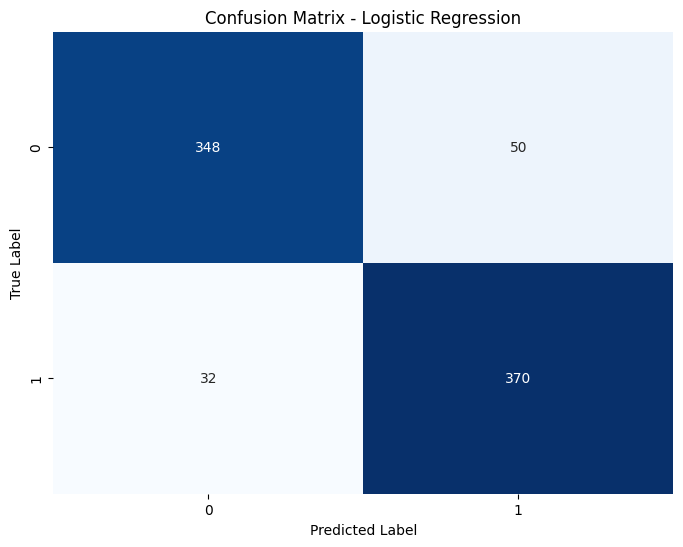


Training Random Forest...
Cross-validation accuracy: 0.8900 (±0.0134)
Validation accuracy: 0.8862
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       398
           1       0.86      0.93      0.89       402

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



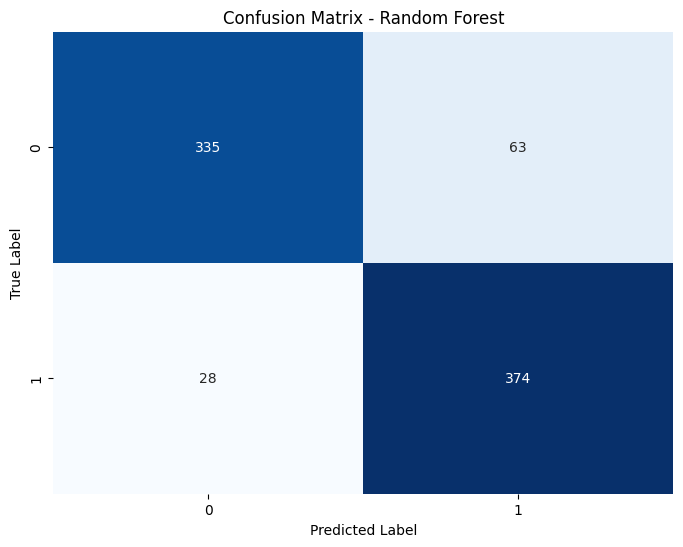


Training Gradient Boosting...
Cross-validation accuracy: 0.9000 (±0.0052)
Validation accuracy: 0.8975
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       398
           1       0.88      0.93      0.90       402

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



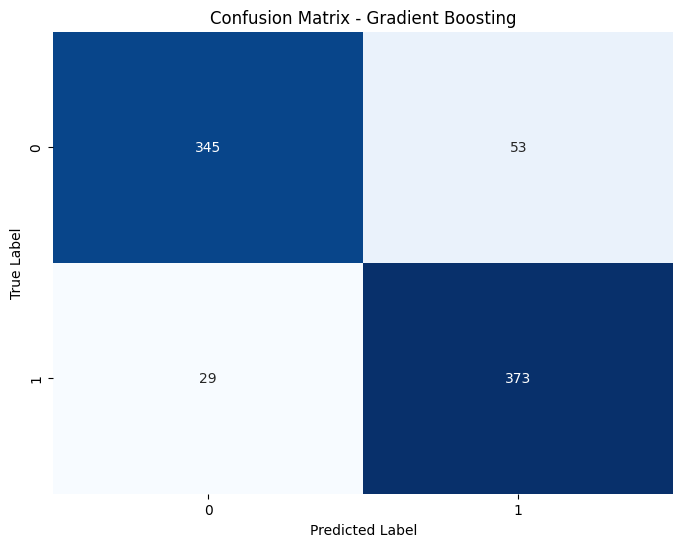


Training XGBoost...
Cross-validation accuracy: 0.8990 (±0.0074)
Validation accuracy: 0.9062
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       398
           1       0.90      0.92      0.91       402

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



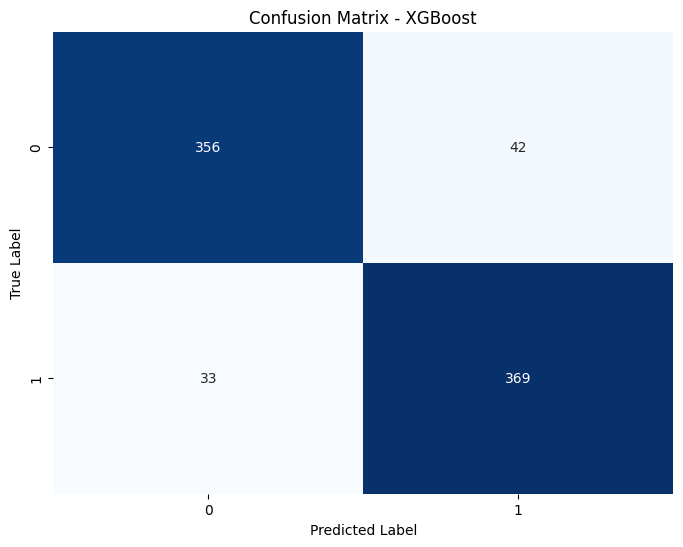


Training LightGBM...
[LightGBM] [Info] Number of positive: 1607, number of negative: 1593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1359
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502188 -> initscore=0.008750
[LightGBM] [Info] Start training from score 0.008750
[LightGBM] [Info] Number of positive: 1607, number of negative: 1593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 115
[L

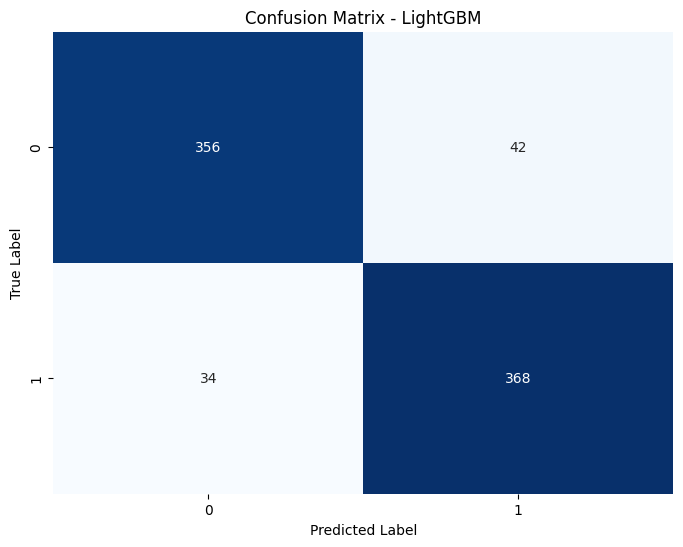

In [89]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # Train on the training set
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipeline.predict(X_val)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)

    # Store results
    model_results[name] = {
        'pipeline': pipeline,
        'cv_accuracy': cv_scores.mean(),
        'validation_accuracy': accuracy
    }

    print(f"Validation accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

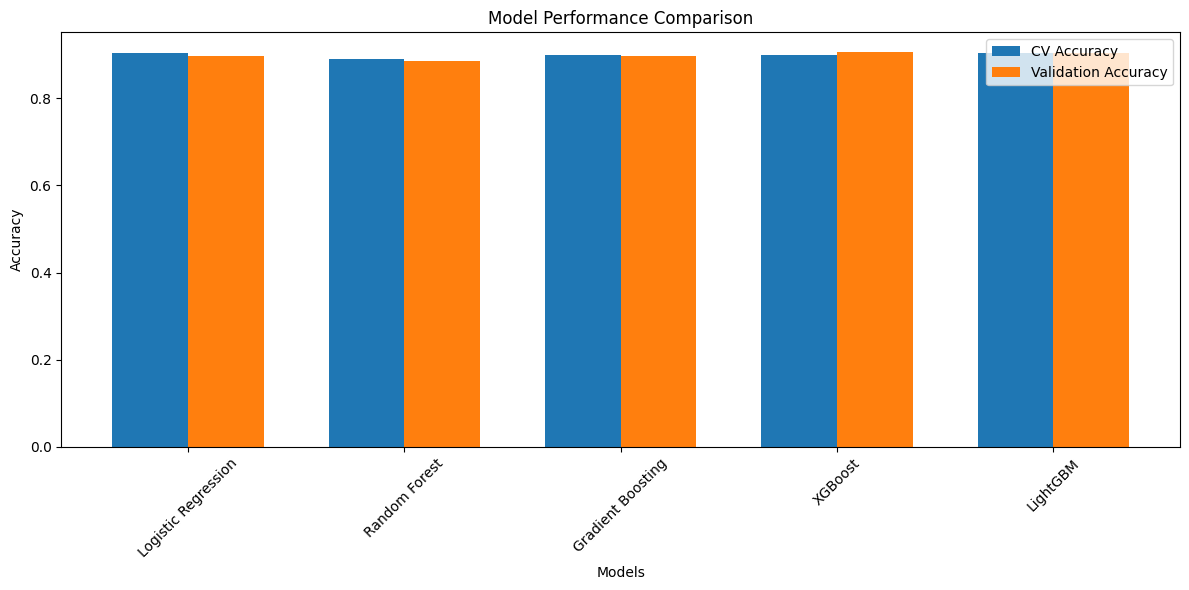

In [90]:
# Compare model performances
cv_scores = [model_results[name]['cv_accuracy'] for name in models]
val_scores = [model_results[name]['validation_accuracy'] for name in models]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, cv_scores, width, label='CV Accuracy')
plt.bar(x + width/2, val_scores, width, label='Validation Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# Identify the best performing model
best_model_name = max(model_results, key=lambda k: model_results[k]['validation_accuracy'])
best_model = model_results[best_model_name]['pipeline']
best_accuracy = model_results[best_model_name]['validation_accuracy']

print(f"\nBest performing model: {best_model_name} with validation accuracy: {best_accuracy:.4f}")


Best performing model: XGBoost with validation accuracy: 0.9062


# 6. Hyperparameter Tuniing FOR THE BEST MODEL

In [ ]:
# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

In [92]:
# Perform hyperparameter tuning for the best model
print(f"Tuning hyperparameters for {best_model_name}...")

grid_search = GridSearchCV(
    best_model,
    param_grid=param_grids[best_model_name],
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Use the tuned model for final prediction
tuned_model = grid_search.best_estimator_

Tuning hyperparameters for XGBoost...
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Best cross-validation accuracy: 0.9078


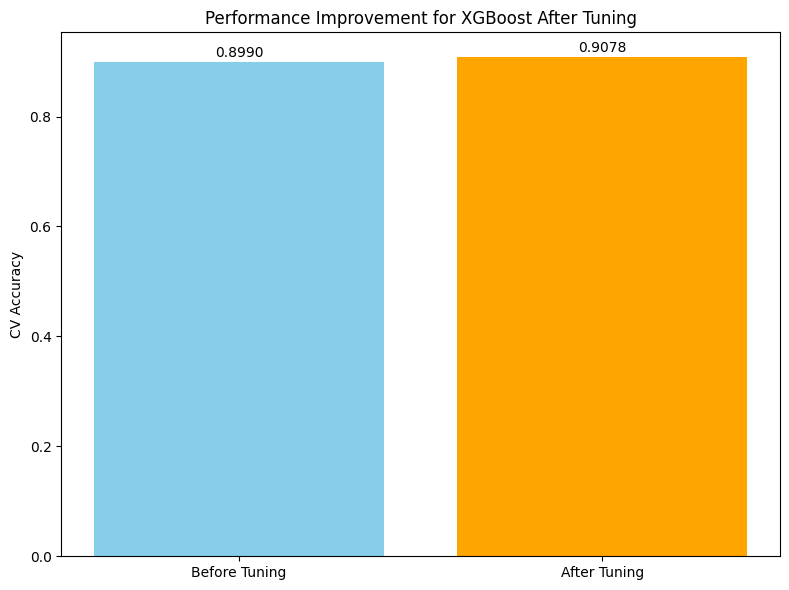

In [93]:
# Show improvement with tuning
plt.figure(figsize=(8, 6))
scores = [model_results[best_model_name]['cv_accuracy'], grid_search.best_score_]
plt.bar(['Before Tuning', 'After Tuning'], scores, color=['skyblue', 'orange'])
plt.ylabel('CV Accuracy')
plt.title(f'Performance Improvement for {best_model_name} After Tuning')
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# 7. Feature Importance Analysis

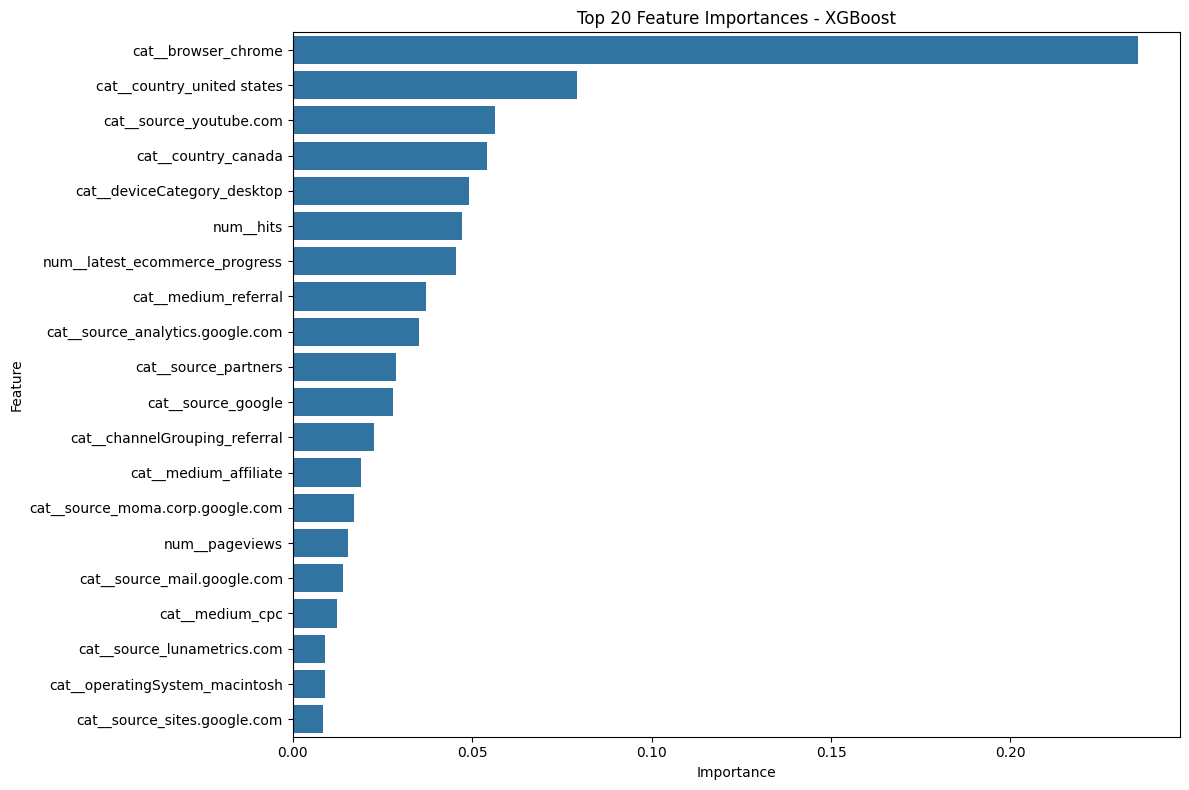

Top 10 most important features:
                               Feature  Importance
4115               cat__browser_chrome    0.235486
4221        cat__country_united states    0.079332
4089           cat__source_youtube.com    0.056256
4143               cat__country_canada    0.053997
4102       cat__deviceCategory_desktop    0.049031
3                            num__hits    0.047181
5       num__latest_ecommerce_progress    0.045404
4094              cat__medium_referral    0.037251
4018  cat__source_analytics.google.com    0.035064
4064              cat__source_partners    0.028751


In [94]:
# Models that support feature importance directly
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']

if best_model_name in tree_based_models:
    # Extract feature names after preprocessing
    preprocessor = tuned_model.named_steps['preprocessor']
    model = tuned_model.named_steps['model']

    # Preprocess the data to get the feature names
    X_processed = preprocessor.transform(X)

    # Try to get feature names from the preprocessor
    feature_names = []
    try:
        # For newer scikit-learn versions
        feature_names = preprocessor.get_feature_names_out()
    except:
        # For older scikit-learn versions or fallback
        ohe_features = []
        if categorical_features:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            ohe_features = [f"{col}_{cat}" for i, col in enumerate(categorical_features)
                           for cat in ohe.categories_[i]]
        feature_names = numerical_features + ohe_features

    # Get feature importances
    importances = model.feature_importances_

    # Create a dataframe of feature importances
    if len(feature_names) == len(importances):
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort by importance
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.show()

        print("Top 10 most important features:")
        print(feature_importance_df.head(10))
    else:
        print("Could not match feature names with importance values")

# 8. Final Prediction

In [ ]:
# Prepare test data
X_test = test_engineered[features]

In [ ]:
# Generate predictions
test_predictions = tuned_model.predict(X_test)
test_probabilities = tuned_model.predict_proba(X_test)[:, 1]  # Probability of class 1

In [ ]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_engineered['id'],
    'will_buy_on_return_visit': test_predictions
})

In [ ]:
# Save submission file
submission_df.to_csv('ML_A_5025231053_FARHAN NAZRUL.csv', index=False)
print("Submission file created: ML_A_5025231053_FARHAN NAZRUL.csv")

Submission file created: ML_A_5025231053_FARHAN NAZRUL.csv


In [ ]:
# Create a more detailed submission with probabilities (for analysis)
detailed_submission = pd.DataFrame({
    'id': test_engineered['id'],
    'predicted_class': test_predictions,
    'probability_class_1': test_probabilities
})

detailed_submission.to_csv('detailed_predictions.csv', index=False)
print("Detailed predictions saved as detailed_predictions.csv")

Detailed predictions saved as detailed_predictions.csv


# 9. Model Summary and Conclusion

In [95]:
print(f"Best model: {best_model_name}")
print(f"Best cross-validation accuracy after tuning: {grid_search.best_score_:.4f}")
print(f"Final model parameters: {grid_search.best_params_}")

print("\nPROJECT COMPLETED SUCCESSFULLY!")

Best model: XGBoost
Best cross-validation accuracy after tuning: 0.9078
Final model parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}

PROJECT COMPLETED SUCCESSFULLY!
